# Model

In [94]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction import text

from sklearn.ensemble import RandomForestClassifier
# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [47]:
df = pd.read_csv('corpus_clean.csv')

In [48]:
text.ENGLISH_STOP_WORDS

add_stop_words = ['don', 'ha', 'x200b', 'wa', 'just']

stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

In [49]:
X = df['alltext']
y = df['target']

In [50]:
y.value_counts(normalize = True)

0    0.589091
1    0.410909
Name: target, dtype: float64

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

In [73]:
y_test.value_counts(normalize = True)

0    0.589077
1    0.410923
Name: target, dtype: float64

### Count Vectorizer and Random Forest

In [95]:
cvec = CountVectorizer(analyzer = "word", 
                       tokenizer = None, 
                       preprocessor = None,
                       stop_words = stop_words, 
                       max_features = 10000, 
                       ngram_range = (1, 3)
                      )
rf = RandomForestClassifier(random_state = 42)

pipe = Pipeline([
    ('cvec', cvec),
    ('rf', rf)
])

pipe.fit(X_train, y_train)
print('train score:', pipe.score(X_train, y_train))
print('test score:', pipe.score(X_test, y_test))

train score: 0.9955560372859311
test score: 0.8332249674902471


In [96]:
rf_feat = cvec.get_feature_names()
rf_feat_imp = rf.feature_importances_

df_rf_feat02 = pd.DataFrame(data=rf_feat_imp, index=rf_feat)

df_rf_feat02.columns = ['feature_importances_']

In [98]:
df_rf_feat02.sort_values(by='feature_importances_', ascending=False).head(20)

,feature_importances_
startup,0.067763
business,0.021171
founder,0.015677
small business,0.013010
small,0.010329
investor,0.007642
app,0.007237
nan,0.006863
saas,0.006712
user,0.006631


## Multinomial Naive Bayes model¶
### CountVectorizer

In [74]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [75]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2000, 3000, 4000, 5000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [76]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [77]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [78]:
# What's the best score?
gs.best_score_

0.8203988995469587

In [79]:
# Score model on training set.
gs.score(X_train, y_train)

0.8375243876002602

In [80]:
# Score model on testing set.
gs.score(X_test, y_test)

0.8107932379713915

In [81]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

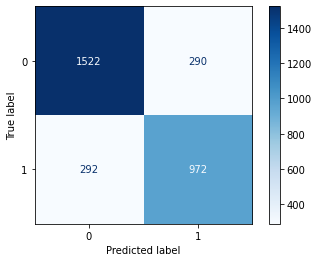

In [82]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

### TF-IDF Vectorizer

In [83]:
# Instantiate the transformer.
tvec = TfidfVectorizer(stop_words=stop_words)

In [84]:
# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names())

In [85]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [86]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).


pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english', stop_words],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [87]:
# Instantiate GridSearchCV.
gs_pipe = GridSearchCV(pipe_tvec,
                      pipe_tvec_params,
                      cv=5)

In [88]:
# Fit GridSearch to training data.
gs_pipe.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english',
                                              frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                                         'almost', 'alone',
                                                         'along', 'already',
                                                         'also', 'although',
                                                         'always', 'am',
                                 

In [99]:
# Score model on training and test set.
gs_pipe.score(X_train, y_train), gs_pipe.score(X_test, y_test)

(0.8533492304357251, 0.8215214564369311)

In [91]:
# # Get predictions
preds_tvec = gs_pipe.predict(X_test)

# # Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# # Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Specificity: 0.8990066225165563


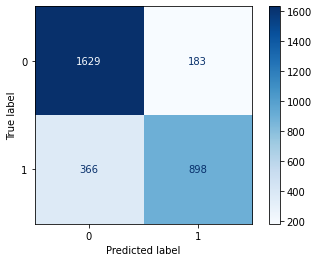

In [92]:
plot_confusion_matrix(gs_pipe, X_test, y_test, cmap='Blues', values_format='d');